## Methodology
The process for conducting our research and modeling will follow the iterative OSEMiN pipeline. This entails obtaining, scrubbing, exploring, modeling, and interpreting the data. 

## Obtaining the Data

Importing the data and any modules needed to understand it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from collections import Counter
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from scipy import stats
from math import log 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb 
from sklearn import svm
from sklearn.svm import SVC
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance

plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
#open dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#getting data info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

## Scrubbing the Data
- Manage datatypes
- Resolve missing/duplicate values.

In [4]:
#checking null values
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [5]:
#dropping duplicate rows 
df.drop_duplicates()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [6]:
# Check out spread of data and outliers
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## Exploring the Data
- Find patterns among the relationships of variables in the dataset.  

#### Exploring the Target variable: 'Churn'

From the countplot below we can see that our target varibale is imablanced, this means that we will need to use SMOTE later. 

False    2850
True      483
Name: churn, dtype: int64

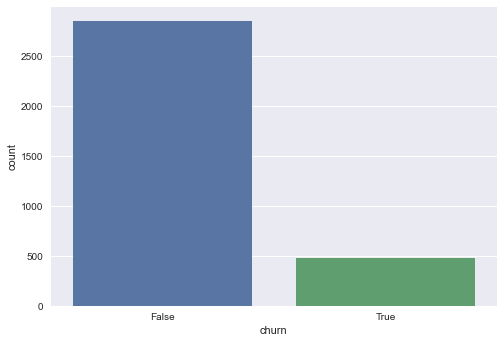

In [7]:
# Check balance of target data 
sns.countplot(x='churn', data=df);
df['churn'].value_counts()

In [8]:
# Check for nonsensical or placeholder values
# We can see that DC is included at the 51st State
for col in df.columns:
    print(col)
    print(df[col].unique())
    print('\n-----------------------------------------------\n')


state
['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

-----------------------------------------------

account length
[128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 186

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

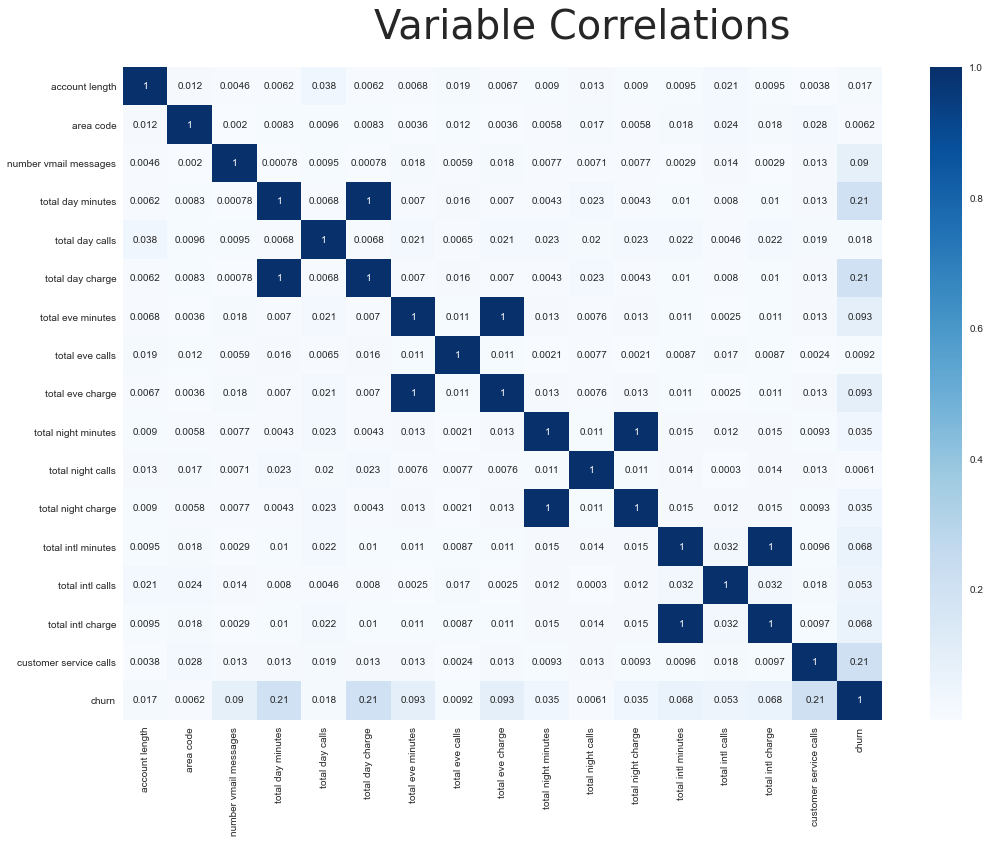

In [10]:
#checking variable correlations 
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

From this correlation map we can see that the charge columns are highly multicollinear with the minutes column. 

In [11]:
#use seaborn pairplot
#code is commented out to save time.  Pairplot will take a few minutes to run

sns_plot = sns.pairplot(data=df, height=2.0)
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
plt.show()



<Figure size 2448x2448 with 0 Axes>

#### Dropping unneccasary columns

For this project we are focused on the services and prices SyriaTel provides on the national level, so individual phone numbers and area codes are not necessary in this case. We also dropped the charge columns because they were multicollinear and added unnecessary noise to our dataset. 

In [12]:
#removing white space from column names 
df.columns = df.columns.str.replace(' ', '_')
#dropping charge columns 
df = df.drop([x for x in df.columns if x.endswith('_charge')],axis=1)
#dropping phone number because it is basically a Unique ID which we do not need for this data set 
df.drop('phone_number', axis=1, inplace=True)
df.drop('area_code', axis=1, inplace=True)
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,KS,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,OH,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,NJ,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,OH,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,OK,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


#### Converting categorical data

- state
- international_plan 
- voice_mail_plan 
- churns  

We need to convert these so that we may intepret the data. 

In [13]:
#one hot encoding 
origin = df['state']
origin_series = pd.Series(origin)
df['state'] = origin_series.astype('category')
df['state'] = df['state'].cat.codes
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,16,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,35,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,31,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,35,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,36,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


In [14]:
#Converting international_plan, voice_mail_plan, and churn to be 1 or 0 
#1= yes/true 0= no/false
df['international_plan'] = df['international_plan'].map(lambda x:1 if x == 'yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x:1 if x == 'yes' else 0)
df['churn'] = df['churn'].map(lambda x:1 if x == True else 0)

df

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,16,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,49,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,39,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,6,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0


#### Define X and y

- Target variable (y): 'churn'
- Features (X): all othre columns

In [15]:
#Defining churn as our target (y)
#Defining the rest of the columns as our features (X)
y = df['churn']
X = df.drop(columns='churn', axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   int8   
 1   account_length          3333 non-null   int64  
 2   international_plan      3333 non-null   int64  
 3   voice_mail_plan         3333 non-null   int64  
 4   number_vmail_messages   3333 non-null   int64  
 5   total_day_minutes       3333 non-null   float64
 6   total_day_calls         3333 non-null   int64  
 7   total_eve_minutes       3333 non-null   float64
 8   total_eve_calls         3333 non-null   int64  
 9   total_night_minutes     3333 non-null   float64
 10  total_night_calls       3333 non-null   int64  
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  customer_service_calls  3333 non-null   int64  
 14  churn                   3333 non-null   

#### Train Test Split 

In [17]:
#setting up our train/test split
#stratifying the data due to the large imablance in target classes 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, stratify=y)
# Check size of train and test sets
print(len(X_train), len(X_test), len(y_train), len(y_test))

2499 834 2499 834


## Modeling the Data
- Create baseline model 
- Iterate through different models 

In [18]:
class Model_test():
    
    '''
    This class will be used to quickly test and save models for comparison
    This class was modified from lecture: Classifican Workflow - Flatiron School - Greg Damico
    
    '''
    
    def __init__(self, mod_name, model, X, y, run_cv=True):
        self.name = mod_name
        self.model = model
        self.X = X
        self.y = y
        #cross validation
        self.cv_result = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        
        if run_cv:
            self.cross_val()
        
    def cross_val(self, X=None, y=None, kfolds=5):
        '''
        Perform cross validation on the model.
        '''
        #checks to see if user entered other values for X,y
        cv_X = X if X else self.X 
        cv_y = y if y else self.y
        
        self.cv_results = cross_val_score(self.model,cv_X,cv_y,cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        self.cv_median = np.median(self.cv_results)
    
        
    #display overall summary
    def print_summary(self):
        res_mean = round(self.cv_mean,4)
        res_std = round(self.cv_std,4)
        print('CV Results for {}\n {} +- {} accuracy'.format(self.name,res_mean,res_std))
        
        #print precision, recall, f1
        y_preds = self.model.predict(self.X)
        prec = precision_score(self.y,y_preds,zero_division='warn')
        rec = recall_score(self.y,y_preds,zero_division='warn') 
        f1s = f1_score(self.y,y_preds,zero_division='warn')
        
        print('\n\nPrecision:{}\tRecall:{}\tF1_Score:{}'.format(prec,rec,f1s))
        
        #plot roc_curve
        print('\nROC CURVE')
        plot_roc_curve(self.model, self.X, self.y)
        plt.show()
        
        #plot confusion matrix
        print('\nCONFUSION MATRIX')
        plot_confusion_matrix(self.model,self.X, self.y,cmap='YlGnBu')
        plt.show()
   #returns the models recall score.  This is our chosen metric.      
    def model_recall(self):
        y_preds = self.model.predict(self.X)
        return recall_score(self.y,y_preds,zero_division='warn') 
        
        

### Baseline Dummy Model 
We are creating a dummy model to serve as our baseline. This dummy model will pick most dominant class in our, in this case 'no churn' which occurs 85% of the time. This means the dummy model should have 85% accuracy. 

CV Results for Dummy Model
 0.8551 +- 0.0009 accuracy


Precision:0.0	Recall:0.0	F1_Score:0.0

ROC CURVE


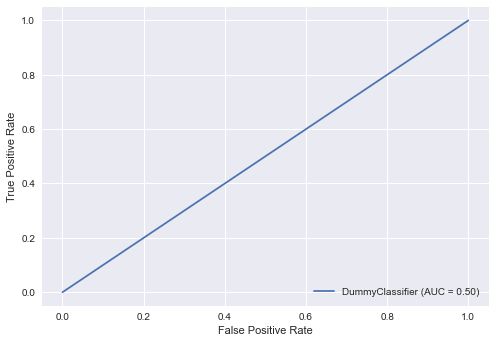


CONFUSION MATRIX


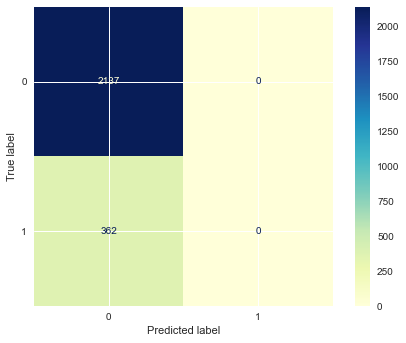

In [19]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train, y_train)
dm_result = Model_test('Dummy Model', dm, X_train, y_train)
dm_result.print_summary()

The AUC-ROC curve for our baseline dummy model should be a diagnol line from 0.0 to 0.1, this is because our dummy model should be no better than a 50/50 guess. Any AUC-ROS curve above the baseline curve indicates that it is performing better than the baseline. 

In [20]:
dm_result.model_recall()

0.0

In [21]:
##create a dictionary to store results of tests
model_dict = {}
model_dict['baseline'] = dm_result.model_recall()
model_dict

{'baseline': 0.0}

#### Scaling the Data
The data is being standardized since the features in the dataset have different ranges. 

In [22]:
#Instantiate StandardScaler
scaler = StandardScaler()

#Transform X_train to scaled data set and fit the model with scaled X train data
scaled_X_train = scaler.fit_transform(X_train)

#Transform X_test to scaled data set
scaled_X_test= scaler.transform(X_test)

#Convert scaled data into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

#### SMOTENC - Synthetic Minority Over-sampling Technique for Nominal and Continuous
From the above data we can see that there is a class imbalance in our target variable, 'churn', so we will use SMOTENC to synthesize data to level out the imbalance. Currently, we are 85% no churn and 15% churn.  We are using SMOTENC due to have binary columns. 



In [23]:
from imblearn.over_sampling import SMOTE,SMOTENC
# Create instance of smotec
smote = SMOTENC(categorical_features=[0, 1, 2, 3], random_state=56)

# Create resampled version of the train dataset
resampled_X_train, resampled_y_train = smote.fit_resample(scaled_X_train, y_train)


In [24]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', resampled_y_train.value_counts())

Before Smote
 0    2137
1     362
Name: churn, dtype: int64

After Smote
 1    2137
0    2137
Name: churn, dtype: int64


### Logistic Regression Model 

Now that we have our baseline model we can begin trying out different models. 

CV Results for Logistic Regression
 0.8487 +- 0.0075 accuracy


Precision:0.39344262295081966	Recall:0.06629834254143646	F1_Score:0.11347517730496454

ROC CURVE


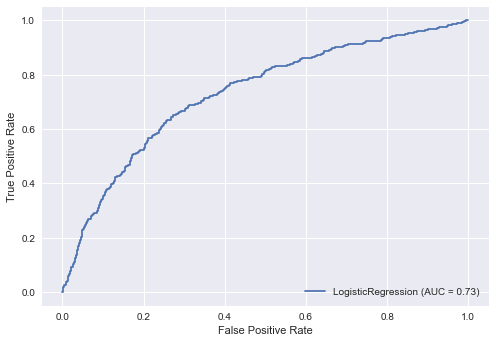


CONFUSION MATRIX


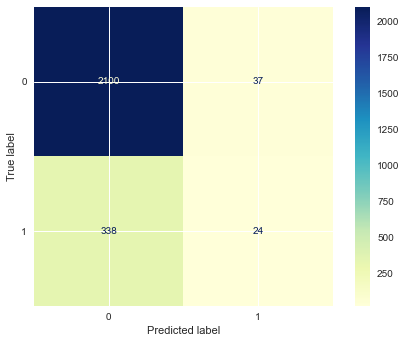

In [25]:
lr= LogisticRegression(random_state = 56)
lr.fit(X_train,y_train)
lr_result = Model_test('Logistic Regression', lr, X_train, y_train)
lr_result.print_summary()

In [26]:
model_dict['logistic regression'] = lr_result.model_recall()
model_dict

{'baseline': 0.0, 'logistic regression': 0.06629834254143646}

### Logistic Regression Model with resampled and standardized data

Let's run the logistic regression again on our resampled data. 

CV Results for Logistic Regression
 0.7651 +- 0.0145 accuracy


Precision:0.7634949679780421	Recall:0.7810014038371549	F1_Score:0.7721489706222531

ROC CURVE


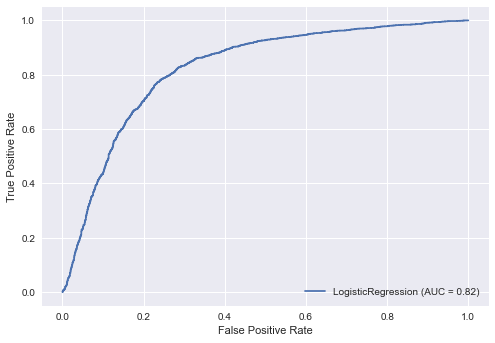


CONFUSION MATRIX


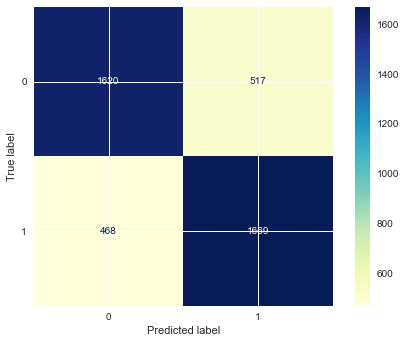

In [27]:
lr.fit(resampled_X_train, resampled_y_train)
lr_result_b = Model_test('Logistic Regression', lr, resampled_X_train, resampled_y_train)
lr_result_b.print_summary()

In [28]:
model_dict['logistic regression balanced'] = lr_result_b.model_recall()
model_dict

{'baseline': 0.0,
 'logistic regression': 0.06629834254143646,
 'logistic regression balanced': 0.7810014038371549}

By standardizing the data and dealing with our class imbalance using SMOTEC we can see the recall score has jumped from 0.06 with an accuracy of 0.85 to a recall score of 0.83 and an accuracy of 0.73. 

## Decision Tree

In [29]:
# Instantiate a DecisionTreeClassifier()
dt= DecisionTreeClassifier(max_depth=3, random_state=56)

CV Results for Decision Tree
 0.9032 +- 0.0145 accuracy


Precision:0.9030303030303031	Recall:0.4116022099447514	F1_Score:0.5654648956356737

ROC CURVE


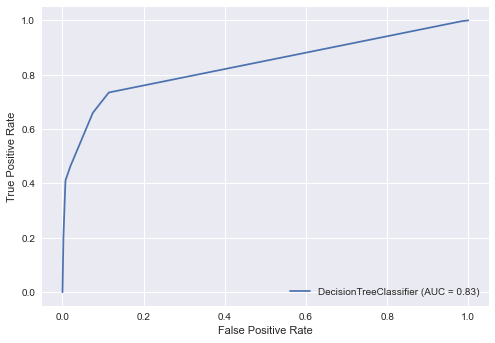


CONFUSION MATRIX


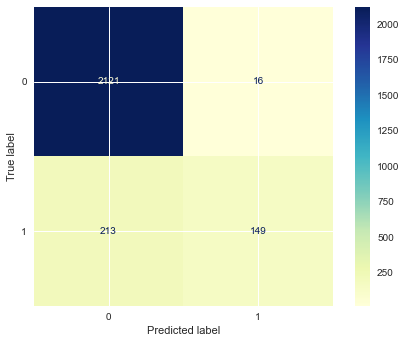

In [30]:
#running a decision tree on our imbalanced dataset
dt.fit(X_train, y_train)
dt_result= Model_test('Decision Tree', dt, X_train, y_train)
dt_result.print_summary()

In [31]:
model_dict['decision tree'] = dt_result.model_recall()
model_dict

{'baseline': 0.0,
 'logistic regression': 0.06629834254143646,
 'logistic regression balanced': 0.7810014038371549,
 'decision tree': 0.4116022099447514}

CV Results for Decision Tree
 0.8383 +- 0.009 accuracy


Precision:0.8670694864048338	Recall:0.8058025269068788	F1_Score:0.8353140916808149

ROC CURVE


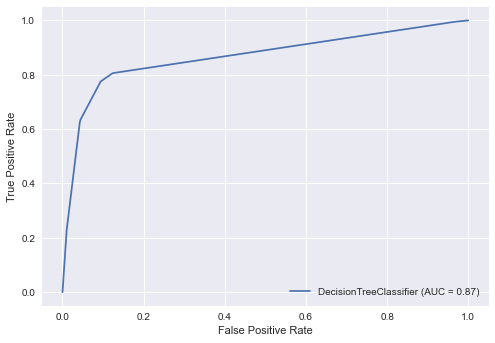


CONFUSION MATRIX


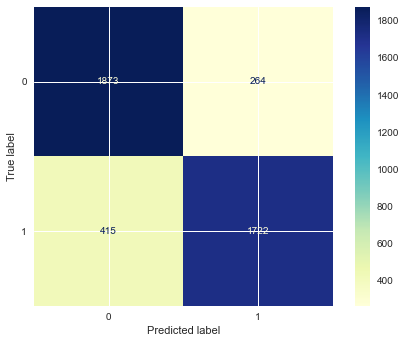

In [32]:
#running a decision tree on our balanced dataset
dt.fit(resampled_X_train, resampled_y_train)
dt_result_b= Model_test('Decision Tree', dt, resampled_X_train, resampled_y_train)
dt_result_b.print_summary()

In [33]:
model_dict['decision tree balanced'] = dt_result_b.model_recall()
model_dict

{'baseline': 0.0,
 'logistic regression': 0.06629834254143646,
 'logistic regression balanced': 0.7810014038371549,
 'decision tree': 0.4116022099447514,
 'decision tree balanced': 0.8058025269068788}

## Random Forest

While our decision tree results were good they are prone to overfitting the data. Using a random forest model should help. Random Forest models help with overfitting by creating many trees. The ensemble of trees prevents the model from overfitting. 

In [ ]:
rf = RandomForestClassifier(random_state =56)
#parameters for RandomForestClassifier
params={'min_samples_leaf':[1,5,10],
       'criterion':['gini','entropy'],
        'max_depth':[7,10,13]}
#create a GridSearchCV
gs=GridSearchCV(estimator=rf,param_grid=params,cv=10,scoring="recall")

In [ ]:
#running a Random Forest on our imbalanced dataset
gs.fit(X_train, y_train)
rf_result= Model_test('Random Forest', gs, X_train, y_train)
rf_result.print_summary()

In [ ]:
model_dict['random forest'] = rf_result.model_recall()
model_dict

In [ ]:
#running a random forest on our balanced dataset
gs.fit(resampled_X_train, resampled_y_train)
rf_result_b= Model_test('Random Forest', gs, resampled_X_train, resampled_y_train)
rf_result_b.print_summary()

In [ ]:
model_dict['random forest balanced'] = rf_result_b.model_recall()
model_dict

## XG Boost Model

In [ ]:
xg = XGBClassifier(random_state =56)

In [ ]:
#running XG Boost Model on our imbalanced dataset
xg.fit(X_train, y_train)
xg_result= Model_test('XG', xg, X_train, y_train)
rf_result.print_summary()

In [ ]:
model_dict['XG'] = xg_result.model_recall()
model_dict

In [ ]:
#running XG Boost on our resampled data 
xg.fit(resampled_X_train, resampled_y_train)
xg_result_b= Model_test('XG balanced', xg, resampled_X_train, resampled_y_train)
xg_result_b.print_summary()

In [ ]:
model_dict['XG balanced'] = xg_result_b.model_recall()
model_dict

## Hypertuning the best model 
 

### Model results:

As we can see from our model results our best performing model is logistic regression and decision trees on a balanced dataset. 


In [ ]:
model_dict

In [ ]:
#auc_roc
plot_roc_curve(lr, resampled_X_train, resampled_y_train)

### Using Grid Search for parameter tuning on balanced logistic regression

In [ ]:
clf = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
gs_lr = GridSearchCV(clf, param_grid = param_grid ,scoring = 'recall')
gs_lr.fit(resampled_X_train, resampled_y_train)
best_parameters = gs_lr.best_params_


print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gs_lr.predict(resampled_X_train)
test_preds = gs_lr.predict(X_test)
training_accuracy = accuracy_score(resampled_y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
lr_grid=LogisticRegression(penalty='l2', C = 5)

In [ ]:
lr_grid.fit(resampled_X_train, resampled_y_train)
y_pred = lr_grid.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

### Using Grid Search for parameter tuning on balanced decision tree model

In [ ]:
clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 5, 10, 15, 20, 100, 150, 250, 500, 1000],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(dt, param_grid, cv=3,scoring='recall', n_jobs=1)
gs_tree.fit(resampled_X_train, resampled_y_train)

best_parameters = gs_tree.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gs_tree.predict(resampled_X_train)
test_preds = gs_tree.predict(X_test)
training_accuracy = accuracy_score(resampled_y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


In [ ]:
dt_grid = DecisionTreeClassifier(criterion='gini', max_depth = 100, min_samples_split=5)


In [ ]:
dt_grid.fit(resampled_X_train, resampled_y_train)
y_pred = dt_grid.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

ht = hypertuned n = not hypertuned

|Model     |Recall   |Accuracy|
|--------------|-----------|------------|
|logistic regression (ht) |0.81  |0.75      |
|logistic regression (n)   |0.81  |0.75     |
|decision tree (ht) |0.74 |0.88 |
|decision tree (n) | 0.79 | 0.85 |

## Interpreting the Data
- Identify insights and visualize findings.

### Final Model on Test Data

We will now use our final model on our text data. Our final model was our tuned, balanced decision tree. 


In [ ]:
from imblearn.over_sampling import SMOTE,SMOTENC
# Create instance of smotec
smote = SMOTENC(categorical_features=[0, 1, 2, 3],random_state=56)

# Create resampled version of the test dataset
resampled_X_test, resampled_y_test = smote.fit_resample(scaled_X_test, y_test)

In [ ]:
#before smote
print('Before Smote\n', y_test.value_counts())

#after smote
print('\nAfter Smote\n', resampled_y_test.value_counts())

In [ ]:
#dt_grid.fit(resampled_X_test, resampled_y_test)
y_pred = dt_grid.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

In [ ]:
#auc_roc
plot_roc_curve(dt_grid, resampled_X_test, resampled_y_test)

In [ ]:
print('Train Score:', dt_grid.score(scaled_X_train, y_train))
print('Test Score:', dt_grid.score(scaled_X_test, y_test))

### Feature Importance on Decision Tree Model 

By using scikit learns feature importance we can see what variables most impacted customer churn rate. 

In [ ]:
#Using feature importance 
feature_importances = dt_grid.feature_importances_

# Create a list of features: done
feature_list = list(resampled_X_train.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

The 3 most important features found were:
- total_day_minutes 
- customer_service_calls 
- total_intl_calls 